In [1]:
# Nash Cascade Neural Network
# A hydrologically intuitive deep learning network

# Set up a solution to a network of buckets where the number of buckets in each layer
# flows out to the buckets in the next layer
# The parameter on each bucket is the size and height of each spigot.

# Need a function that solves this individually at a single buckets
# Then a function that loops through and moves the water to the downstream buckets

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
G = 9.81

In [3]:
# Initialize some flow into the system
U = [np.round(np.random.random()) for u in range(100)]

In [4]:
# Initialize the network size
Buckets_Per_Layer = [1,2,3,5,10,15,5,3,2,1] # Buckets Per Layer

In [5]:
def get_initial_parameters_of_one_bucket(n_spigots):
    """
        returns tupple: {height, area, q}
    """
    s_parameters = [[np.random.random(),np.random.random()] for _ in range(n_spigots)]
    return s_parameters

In [6]:
def initialize_up_bucket_network(bpl):
    """Sets up the network of buckets
        Args: 
            bpl (list): the buckets per layer
        Returns:
            dict: A dictionary with all the buckets organized by layer, 
                  with each layer containing a dictionary, 
                  with keys for Head in the bucket and a list of spigot parms
    """

    # For each layer in the network, set up a dictionary with the bucket characteristics
    bucket_network_dict = {layer:{"H":[], "S":[], "s_q":[]} for layer in range(len(bpl))}
    
    for ilayer, n_buckets in enumerate(bpl):
        if ilayer < len(bpl)-1:
            n_spigots = bpl[ilayer+1]
        else:
            n_spigots = 1
        spigots = [get_initial_parameters_of_one_bucket(n_spigots) for jbucket in range(n_buckets)]
        bucket_network_dict[ilayer]["S"] = spigots
        bucket_network_dict[ilayer]["H"] = [100 for jbucket in range(n_buckets)]
        bucket_network_dict[ilayer]["s_q"] = [[0 for i in range(n_spigots)] for jbucket in range(n_buckets)]
        bucket_network_dict[ilayer]["theta"] = [[np.random.uniform(0.001, 0.01) for i in range(n_spigots)] for jbucket in range(n_buckets)]
    return bucket_network_dict

In [7]:
ncnn = initialize_up_bucket_network(Buckets_Per_Layer)

In [8]:
def solve_single_bucket(H, S, theta, bucket_inflow=0):
    """ solves a single bucket
        Args: 
            H (float): the initial water level in bucket
            S (list): the characteristics of the bucket outlets
                                        spigots[0]: Height of spigots, 
                                        spigots[1]: size of spigots
            theta (list): These are the weights of each bucket outlet (valve)
            inflow (float): The mass going into the bucket from the upstream layer
        Returns:
            H (float): the new water level in bucket
            s_q (list): The flow of water out of each spigot
    """
    H = H + bucket_inflow
    s_q = []
    for S_i, theta_i in zip(S, theta):
        sp_h, sp_a = S_i
        h = np.max([0, H - sp_h])
        v =  theta_i * np.sqrt(2 * G * h)
        flow_out = v * sp_a
        s_q.append(flow_out)
    Q = np.sum(s_q)
    H = H - Q
    
    return H, s_q

In [9]:
def solve_layer_inflows(ncnn, ilayer):

    """ Solves the inflow to the layer from the previous layer
        Args:
            ncnn (dict)
            ilayer (int)
        Returns:
            List: one inflow per bucket in ilayer
    """

    if ilayer == 0:
        inflows = [0]
        return inflows
    
    number_of_ilayer_buckets = len(ncnn[ilayer]["s_q"])
    number_of_upstream_buckets = len(ncnn[ilayer-1]["s_q"])

    inflows = []

    for ibucket in range(number_of_ilayer_buckets):

        i_bucket_q = 0

        for i_up_bucket in range(number_of_upstream_buckets):

            i_bucket_q += ncnn[ilayer-1]["s_q"][i_up_bucket][ibucket]

        inflows.append(i_bucket_q)
        
    return inflows

In [10]:
def update_network(ncnn):
    
    for ilayer in list(ncnn.keys()):

        inflows = solve_layer_inflows(ncnn, ilayer)

        for ibucket in range(len(ncnn[ilayer]["H"])):
            
            H = ncnn[ilayer]["H"][ibucket]
            S = ncnn[ilayer]["S"][ibucket]
            theta = ncnn[ilayer]["theta"][ibucket]

            single_bucket_inflow = inflows[ibucket]

            H, s_q = solve_single_bucket(H, S, theta, single_bucket_inflow)
            
            ncnn[ilayer]["H"][ibucket] = H
            ncnn[ilayer]["s_q"][ibucket] = s_q

    network_outflow = ncnn[list(ncnn.keys())[-1]]["s_q"][0]
    return network_outflow

In [11]:
def summarize_network(ncnn):
    mean_H_per_layer = []
    sum_H_per_layer = []
    for i in list(ncnn.keys()):
        mean_H_per_layer.append(np.mean(ncnn[i]["H"]))
        sum_H_per_layer.append(np.sum(ncnn[i]["H"]))
    return mean_H_per_layer, sum_H_per_layer, np.sum(sum_H_per_layer)

INITIAL network
mean H per layer
[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
sum H per layer
[100, 200, 300, 500, 1000, 1500, 500, 300, 200, 100]
Total Mass in network:  4700


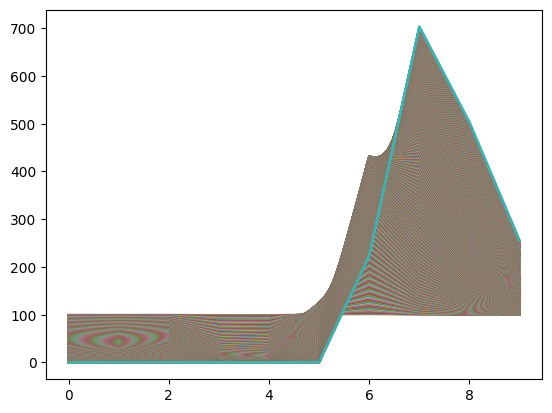

Final network
mean H per layer
[0.024909087003136328, 0.45723763924654837, 0.3967483467730378, 0.05759181717140501, 0.07094533803242455, 0.5671791151672896, 223.15005679916868, 703.5165618474663, 503.44577199885396, 255.49568309003266]
sum H per layer
[0.024909087003136328, 0.9144752784930967, 1.1902450403191134, 0.28795908585702507, 0.7094533803242454, 8.507686727509343, 1115.7502839958433, 2110.549685542399, 1006.8915439977079, 255.49568309003266]
Total Mass in network:  4500.3219252254885
Total Mass out of network 199.67807477451322
Total Mass in and out of network 4700.000000000002


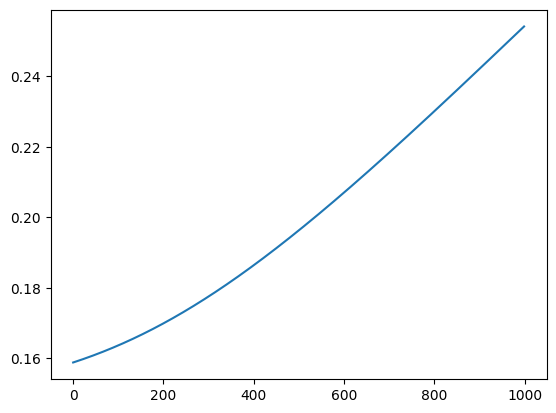

In [12]:
mean_H_per_layer, sum_H_per_layer, sum_sum_H_per_layer = summarize_network(ncnn)
print("INITIAL network")
print("mean H per layer")
print(mean_H_per_layer)
print("sum H per layer")
print(sum_H_per_layer)
print("Total Mass in network: ", sum_sum_H_per_layer)
network_outflow_list = []
for i in range(1000):
    network_outflow = update_network(ncnn)
    network_outflow_list.append(network_outflow)
    mean_H_per_layer, sum_H_per_layer, sum_sum_H_per_layer = summarize_network(ncnn)
    plt.plot(mean_H_per_layer)
plt.show()
plt.close()
print("Final network")
print("mean H per layer")
print(mean_H_per_layer)
print("sum H per layer")
print(sum_H_per_layer)
print("Total Mass in network: ", sum_sum_H_per_layer)
print("Total Mass out of network", np.sum(network_outflow_list))
print("Total Mass in and out of network", sum_sum_H_per_layer + np.sum(network_outflow_list))
plt.plot(network_outflow_list)
plt.show()
plt.close()